# User interface: the compressed likelihood

This notebook focuses on the final product, and how we expect most (non-experts) users to use our compressed likelihood. 

By compressed likelihood we mean a likelihood that has already marginalized over nuisance (astro) parameters, and that uses a reduced set of parameters to describe the cosmological model. 

The compressed likelihood doesn't know about redshift bins, or band powers, it doesn't know about mean flux, temperature or redshift or reionization.

Summary:
    - Given an input cosmological model, it computes the parameters describing the linear power spectrum (linP).
    - Given a set of linP parameters, it calls a precomputed object with the likelihood for these parameters. For this notebook, the precomputed object is just a Gaussian fit to ($\Delta_p^2$,$n_{\rm eff}$), i.e., amplitude and slope of the linaer power at $z=3$ and $k_p= 0.009 s/km$.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib.pyplot as plt
from cup1d.interface import marg_lya_like
from cup1d.cosmology import camb_cosmo
from cup1d.cosmology import fit_linP

## Plot marginalised likelihoods

This is the likelihood that has already been marginalized over nuisance parameters, and is of course, experiment specific. At this point it has lost all information about nuisance parameters, or data points. 

Here we use Gaussian approximations to some published likelihoods.

### Compare McDonald et al. (2005) vs Chabanier et al. (2019)

Note that we approximate the likelihood from McDonald as a Gaussian, not a good approximation!

Text(0, 0.5, '$\\Delta_p^2$')

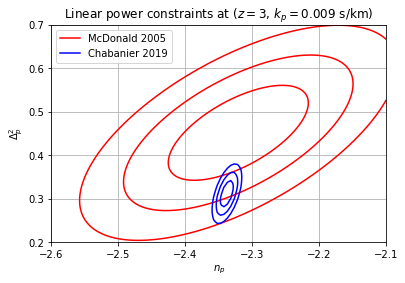

In [2]:
# create grid (note j in number of elements, crazy python)
neff_grid,DL2_grid = np.mgrid[-2.6:-2.1:100j, 0.2:0.7:100j]
chi2_McDonald2005=marg_lya_like.gaussian_chi2_McDonald2005(neff_grid,DL2_grid)
chi2_Chabanier2019=marg_lya_like.gaussian_chi2_Chabanier2019(neff_grid,DL2_grid)
thresholds = [2.30,6.17,11.8]
plt.contour(neff_grid,DL2_grid,chi2_McDonald2005,levels=thresholds,colors='red')
plt.contour(neff_grid,DL2_grid,chi2_Chabanier2019,levels=thresholds,colors='blue')
# hack to get legend entry for contours above
plt.axhline(y=0.8,color='red',label='McDonald 2005')
plt.axhline(y=0.8,color='blue',label='Chabanier 2019')
plt.ylim(np.min(DL2_grid),np.max(DL2_grid))
plt.grid()                 
plt.legend(loc=2)
plt.title(r'Linear power constraints at ($z=3$, $k_p=0.009$ s/km)')
plt.xlabel(r'$n_p$')
plt.ylabel(r'$\Delta_p^2$')

### Replicate Figure 20 in Chabanier et al. (2019)


Text(0, 0.5, '$n_p$')

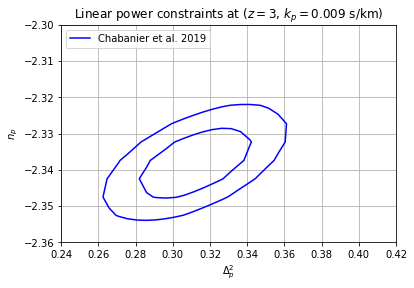

In [3]:
plt.contour(DL2_grid,neff_grid,chi2_Chabanier2019,levels=thresholds[:2],colors='blue')
# hack to get legend entry for contours above
plt.axhline(y=0.8,color='blue',label='Chabanier et al. 2019')
plt.xlim(0.24,0.42)
plt.ylim(-2.36,-2.3)
plt.grid()                 
plt.legend(loc=2)
plt.title(r'Linear power constraints at ($z=3$, $k_p=0.009$ s/km)')
plt.xlabel(r'$\Delta_p^2$')
plt.ylabel(r'$n_p$')

## Compute predictions from several cosmological models

Setup two $\nu\Lambda$CDM cosmological models, with different neutrino masses

In [4]:
# specify cosmology with massless neutrinos
cosmo_mnu0 = camb_cosmo.get_cosmology(mnu=0.0)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo_mnu0)
print('Omega_m =',cosmo_mnu0.omegam)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
Omega_m = 0.3163288037424815


In [5]:
# specify cosmology with massless neutrinos
cosmo_mnu03 = camb_cosmo.get_cosmology(mnu=0.3)
# print relevant information about the cosmology object
camb_cosmo.print_info(cosmo_mnu03)
print('Omega_m =',cosmo_mnu03.omegam)

H0 = 6.7000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 3.2257E-03, T_CMB = 2.7255E+00, A_s = 2.1000E-09, n_s = 9.6500E-01, alpha_s = 0.0000E+00
Omega_m = 0.3235145733898215


### Compute parameters describing the linear power spectrum around $z_\star=3$, $k_p=0.009$ s/km

In [6]:
z_star=3.0
kp_kms=0.009
linP_model_mnu0=fit_linP.LinearPowerModel(cosmo=cosmo_mnu0,z_star=z_star,k_units='kms',kp=kp_kms)
params_mnu0=linP_model_mnu0.get_params()
print('Lya parameters for massless cosmology',params_mnu0)

Lya parameters for massless cosmology {'f_star': 0.981369557840318, 'g_star': 0.9677508579459803, 'Delta2_star': 0.36017590528641974, 'n_star': -2.299335667257498, 'alpha_star': -0.2165270371206895}


In [7]:
linP_model_mnu03=fit_linP.LinearPowerModel(cosmo=cosmo_mnu03,z_star=z_star,k_units='kms',kp=kp_kms)
params_mnu03=linP_model_mnu03.get_params()
print('Lya parameters for massive cosmology',params_mnu03)

Lya parameters for massive cosmology {'f_star': 0.9690024397615455, 'g_star': 0.9687130850033866, 'Delta2_star': 0.3234731288528899, 'n_star': -2.3021240909857736, 'alpha_star': -0.21455144240684618}


In [8]:
# Evaluate marginalised likelihood for these models, using Lya results from Chabanier et al. 
print('mnu=0eV, chi2=',marg_lya_like.gaussian_chi2_Chabanier2019(params_mnu0['n_star'],params_mnu0['Delta2_star']))
print('mnu=0.3eV, chi2=',marg_lya_like.gaussian_chi2_Chabanier2019(params_mnu03['n_star'],params_mnu03['Delta2_star']))

mnu=0eV, chi2= 36.45025297779785
mnu=0.3eV, chi2= 39.1536759323211


Text(0, 0.5, '$n_p$')

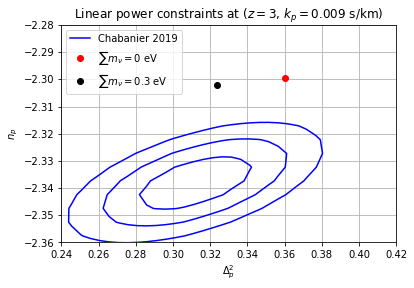

In [9]:
plt.contour(DL2_grid,neff_grid,chi2_Chabanier2019,levels=thresholds,colors='blue')
# hack to get legend entry for contours above
plt.axhline(y=0.8,color='blue',label='Chabanier 2019')
# add point from massless cosmology
plt.plot(params_mnu0['Delta2_star'],params_mnu0['n_star'],'o',color='red',label=r'$\sum m_\nu = 0$ eV')
plt.plot(params_mnu03['Delta2_star'],params_mnu03['n_star'],'o',color='black',label=r'$\sum m_\nu = 0.3$ eV')
plt.xlim(0.24,0.42)
plt.ylim(-2.36,-2.28)
plt.grid()                 
plt.legend(loc=2)
plt.title(r'Linear power constraints at ($z=3$, $k_p=0.009$ s/km)')
plt.xlabel(r'$\Delta_p^2$')
plt.ylabel(r'$n_p$')